In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#for json convertion
import ast

In [2]:
# Load Data Sets
df1 = pd.read_csv('charging_sessions.csv')
df2 = pd.read_csv('weather_burbank_airport.csv')

In [3]:
#control if data was loaded
print(df1.head())
print(df2.head())

   Unnamed: 0                        id             connectionTime  \
0           0  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
1           1  5e23b149f9af8b5fe4b973d0  2020-01-02 13:36:50+00:00   
2           2  5e23b149f9af8b5fe4b973d1  2020-01-02 13:56:35+00:00   
3           3  5e23b149f9af8b5fe4b973d2  2020-01-02 13:59:58+00:00   
4           4  5e23b149f9af8b5fe4b973d3  2020-01-02 14:00:01+00:00   

              disconnectTime           doneChargingTime  kWhDelivered  \
0  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 22:38:21+00:00  2020-01-02 20:18:05+00:00        33.097   
2  2020-01-03 00:39:22+00:00  2020-01-02 16:35:06+00:00         6.521   
3  2020-01-02 16:38:39+00:00  2020-01-02 15:18:45+00:00         2.355   
4  2020-01-02 22:08:40+00:00  2020-01-02 18:17:30+00:00        13.375   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-1

Feature Engineering to focus on the relevant data for clustering

1. Session Duration (minutes): Time between connectionTime and disconnectTime.
2. Charging Duration (minutes): Time between connectionTime and doneChargingTime.
3. Idle Duration (minutes): Time between doneChargingTime and disconnectTime.
4. Charging Efficiency (kWh per minute): kWhDelivered / Charging Duration.
5. User Inputs: Extract fields from the userInputs JSON object (e.g., kWhRequested, minutesAvailable).


In [4]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
df1['connectionTime'] = pd.to_datetime(df1['connectionTime'])
df1['disconnectTime'] = pd.to_datetime(df1['disconnectTime'])
df1['doneChargingTime'] = pd.to_datetime(df1['doneChargingTime'])
#calculating the session duration in minutes
df1['session_duration'] = (df1['disconnectTime'] - df1['connectionTime']).dt.total_seconds() / 60
df1['charging_duration'] = (df1['doneChargingTime'] - df1['connectionTime']).dt.total_seconds() / 60
df1['idle_duration'] = (df1['disconnectTime'] - df1['doneChargingTime']).dt.total_seconds() / 60
df1['charging_efficiency'] = df1['kWhDelivered'] / (df1['charging_duration'] / 60)

In [6]:
print(df1['userInputs'].head(10))  # Show the first 10 entries
print(df1['userInputs'].apply(type).unique())  # Identify the types of data in the column

0    [{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...
1    [{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...
2    [{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...
3    [{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...
4    [{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...
5    [{'WhPerMile': 600, 'kWhRequested': 24.0, 'mil...
6    [{'WhPerMile': 385, 'kWhRequested': 65.45, 'mi...
7    [{'WhPerMile': 300, 'kWhRequested': 45.0, 'mil...
8    [{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil...
9    [{'WhPerMile': 400, 'kWhRequested': 20.0, 'mil...
Name: userInputs, dtype: object
[<class 'str'> <class 'float'>]


In [7]:
#convert userInputs from string and float to lists

def safe_eval(x):
    try:
        # Check if it's a string and try parsing it
        if isinstance(x, str):
            return ast.literal_eval(x)
        # If it's NaN or None, return an empty list
        elif x is None or (isinstance(x, float) and np.isnan(x)):
            return []
        # If it's already a list, return as is
        elif isinstance(x, list):
            return x
        # If it's some other unexpected object, return as is or log a warning
        else:
            return []  # Default to empty list for unrecognized cases
    except (ValueError, SyntaxError, TypeError):
        # Handle parsing errors safely
        return []

# Apply the safe_eval function to the 'userInputs' column
df1['userInputs'] = df1['userInputs'].apply(safe_eval)

# Verify the data types after applying the function
print(df1['userInputs'].apply(type).unique())

[<class 'list'>]


In [8]:
# Explode and normalize userInputs
exploded_user_inputs = df1['userInputs'].explode()

# Normalize the dictionaries into columns
user_inputs_normalized = pd.json_normalize(exploded_user_inputs)

# Restore the original index for merging
user_inputs_normalized['original_index'] = exploded_user_inputs.index

# Merge normalized data back into the original DataFrame
df1 = df1.merge(user_inputs_normalized, left_index=True, right_on='original_index', how='left')

# Drop the auxiliary column
df1.drop(columns=['original_index'], inplace=True, errors='ignore')

# Inspect the updated DataFrame
print(df1.head())

   Unnamed: 0                        id            connectionTime  \
0           0  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
1           1  5e23b149f9af8b5fe4b973d0 2020-01-02 13:36:50+00:00   
2           2  5e23b149f9af8b5fe4b973d1 2020-01-02 13:56:35+00:00   
3           3  5e23b149f9af8b5fe4b973d2 2020-01-02 13:59:58+00:00   
4           3  5e23b149f9af8b5fe4b973d2 2020-01-02 13:59:58+00:00   

             disconnectTime          doneChargingTime  kWhDelivered  \
0 2020-01-02 19:11:15+00:00 2020-01-02 17:31:35+00:00        25.016   
1 2020-01-02 22:38:21+00:00 2020-01-02 20:18:05+00:00        33.097   
2 2020-01-03 00:39:22+00:00 2020-01-02 16:35:06+00:00         6.521   
3 2020-01-02 16:38:39+00:00 2020-01-02 15:18:45+00:00         2.355   
4 2020-01-02 16:38:39+00:00 2020-01-02 15:18:45+00:00         2.355   

                                sessionID  siteID  spaceID    stationID  ...  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-179-810  ...  

In [9]:
print(user_inputs_normalized.head())

   WhPerMile  kWhRequested  milesRequested  minutesAvailable  \
0      250.0          25.0           100.0             463.0   
1      280.0          70.0           250.0             595.0   
2      400.0           8.0            20.0              60.0   
3      400.0           8.0            20.0              65.0   
4      400.0           8.0            20.0              65.0   

                      modifiedAt paymentRequired  \
0  Thu, 02 Jan 2020 13:09:39 GMT            True   
1  Thu, 02 Jan 2020 13:37:11 GMT            True   
2  Thu, 02 Jan 2020 13:57:17 GMT            True   
3  Thu, 02 Jan 2020 14:00:03 GMT            True   
4  Thu, 02 Jan 2020 14:00:19 GMT            True   

              requestedDeparture  userID  original_index  
0  Thu, 02 Jan 2020 20:51:54 GMT   194.0               0  
1  Thu, 02 Jan 2020 23:31:50 GMT  4275.0               1  
2  Thu, 02 Jan 2020 14:56:35 GMT   344.0               2  
3  Thu, 02 Jan 2020 15:04:58 GMT  1117.0               3  
4  Thu,

In [10]:
features = df1[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(features.head())

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        362.350000         262.683333      99.666667             5.713952   
1        541.516667         401.250000     140.266667             4.949084   
2        642.783333         158.516667     484.266667             2.468258   
3        158.683333          78.783333      79.900000             1.793527   
4        158.683333          78.783333      79.900000             1.793527   

   kWhDelivered  
0        25.016  
1        33.097  
2         6.521  
3         2.355  
4         2.355  


Cleaning up the data in "features"

In [11]:
print(features.isnull().sum())  # Check for missing values in each column
print(np.isinf(features).sum())  # Check for infinite values

session_duration          0
charging_duration      5310
idle_duration          5310
charging_efficiency    5310
kWhDelivered              0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    2
kWhDelivered           0
dtype: int64


There are several empty cells in the df. Therefore, there are two possible solutions: 
1. drop all rows with missing values
2. add placeholder values by calculation eg. the mean

In [12]:
#drop rows
#features = features.dropna()

In [13]:
#add placeholders
features.loc[:, 'charging_duration'] = features['charging_duration'].fillna(features['charging_duration'].median())
features.loc[:, 'idle_duration'] = features['idle_duration'].fillna(0)  # Assuming 0 idle time where missing
features.loc[:, 'charging_efficiency'] = features['charging_efficiency'].fillna(features['charging_efficiency'].mean())

In [14]:
#Inspect, where infinite values appear
print(features[np.isinf(features['charging_efficiency'])])

       session_duration  charging_duration  idle_duration  \
4937         666.600000         174.266667            0.0   
4938         275.166667         174.266667            0.0   
4939         483.316667         174.266667            0.0   
4940         151.783333         174.266667            0.0   
4941         517.033333         174.266667            0.0   
...                 ...                ...            ...   
73791        259.450000         174.266667            0.0   
73797         54.433333         174.266667            0.0   
73823         54.266667         174.266667            0.0   
79497         24.366667         174.266667            0.0   
79498         24.366667         174.266667            0.0   

       charging_efficiency  kWhDelivered  
4937                   inf        25.183  
4938                   inf        14.136  
4939                   inf        14.203  
4940                   inf        13.041  
4941                   inf         5.797  
...      

In [15]:
#angepasste Formel zur Division, kann unter Umständen später entfernt werden, falls die Felder in denen nichts 
#steht schon früher im df entfernt wurden
df1['charging_duration'] = df1['charging_duration'].replace(0, np.nan)

In [16]:
# Recalculate charging_efficiency to avoid dividing by zero
df1['charging_efficiency'] = df1['kWhDelivered'] / (df1['charging_duration'] / 60)

In [17]:
# Replace NaN or inf values with a default value (e.g., 0 or median)
df1['charging_efficiency'] = df1['charging_efficiency'].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
df1['charging_efficiency'] = df1['charging_efficiency'].fillna(0)  # Replace NaN with 0

In [18]:
print(features[np.isinf(features['charging_efficiency'])])

       session_duration  charging_duration  idle_duration  \
4937         666.600000         174.266667            0.0   
4938         275.166667         174.266667            0.0   
4939         483.316667         174.266667            0.0   
4940         151.783333         174.266667            0.0   
4941         517.033333         174.266667            0.0   
...                 ...                ...            ...   
73791        259.450000         174.266667            0.0   
73797         54.433333         174.266667            0.0   
73823         54.266667         174.266667            0.0   
79497         24.366667         174.266667            0.0   
79498         24.366667         174.266667            0.0   

       charging_efficiency  kWhDelivered  
4937                   inf        25.183  
4938                   inf        14.136  
4939                   inf        14.203  
4940                   inf        13.041  
4941                   inf         5.797  
...      

In [19]:
#Zellen wurden rausgeworfen - muss man noch anpassen
features = features[~np.isinf(features['charging_efficiency'])]

Normalizing the data for clustering

In [20]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Cluster Analysis

kMean

In [21]:
print(scaled_features.shape)  # Check the number of rows in scaled_features
print(df1.shape)  # Check the number of rows in df1

(75327, 5)
(80639, 25)


In [22]:
scaled_features_cleaned = scaled_features[~np.isinf(features['charging_efficiency']) & features['charging_efficiency'].notna()]

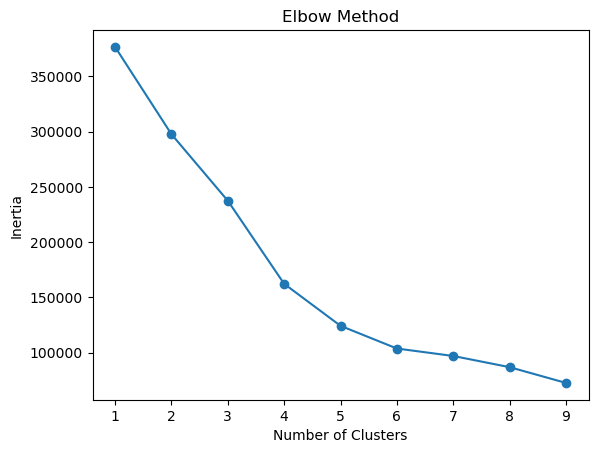

In [23]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleaned)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

In [24]:
cluster_summary = features.groupby('cluster').mean()
print(cluster_summary)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              183.810670         135.747263      48.063408   
1              582.847429         184.223852     398.623577   
2              536.738864         450.191221      86.547643   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   3.873154      8.003806  
1                   3.169650      9.154121  
2                   0.670656     26.975604  


Visualize data with scatterplot

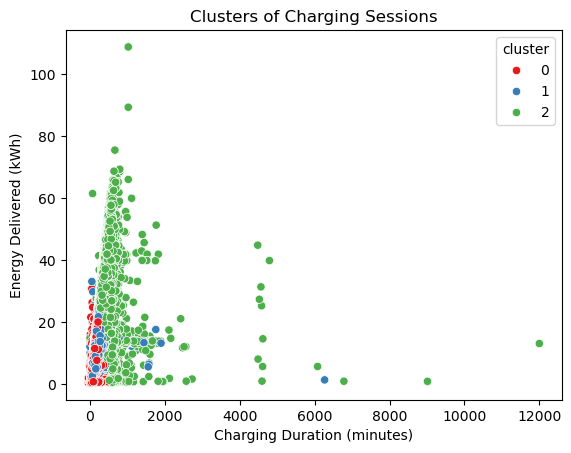

In [25]:
sns.scatterplot(data=features, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

Cluster Descriptions
Cluster 0: Quick Charges

Charging Duration: Short
Energy Delivered: Low
Charging Efficiency: High
Explanation: These are charging sessions that are completed relatively quickly with minimal energy delivered, and the efficiency of charging is high. This could represent users who only need to charge a small amount or those charging at higher power levels, enabling fast but short sessions.

Cluster 1: Standard Charges

Charging Duration: Moderate
Energy Delivered: Moderate
Charging Efficiency: Moderate
Explanation: This is the most typical cluster, where charging duration and energy delivered are in a moderate range. The charging efficiency is also in a normal range, which could represent the bulk of regular charging sessions where users are charging their vehicles for a typical amount of time to a reasonable energy level.

Cluster 2: Long Charges

Charging Duration: Long
Energy Delivered: High
Charging Efficiency: Moderate to low
Explanation: These charging sessions take longer and deliver more energy, often with longer idle times. Efficiency might be lower due to charging inefficiencies or because the vehicles were charged at lower power rates or for extended periods (e.g., overnight charging).

Optimize Infrastructure

Allocation of Chargers: Understanding the different charging behaviors can help optimize the deployment of chargers in certain locations. For example, areas with a high proportion of Long Charges might require more powerful chargers or more charging stations to handle the longer charging durations and higher energy demand. Similarly, Quick Charges can be served by smaller, faster chargers.

Predict Behavior

Demand Forecasting: By recognizing these clusters, you can predict charging behavior and demand patterns for future periods. For instance, Long Charges might be more common during off-peak hours (such as overnight), while Quick Charges may peak during the day. This can help in planning for peak usage times and ensuring adequate infrastructure availability.

Tailored Pricing

Create Pricing Strategies: Each cluster could have different pricing strategies. For example:
Quick Charges could be priced at a premium for efficiency, encouraging fast but short charges during high-demand periods.
Standard Charges might follow a normal pricing strategy.
Long Charges could be incentivized with discounts or flat rates due to their longer duration, or a premium could be charged for high idle time or inefficiency.